creating humidex files to be used as Canrcm4 datasets the usual way, based on rainonsnow function

In [42]:
import xarray as xr
import os
import re
import glob
import xclim

In [43]:
# import config
import tomllib as tomli
with open(r"C:\Users\CAMG038492\Code\Climatology\config.toml","rb") as f:
    conf = tomli.load(f) # Loads configuration settings from a TOML file.

datahome = conf['paths']['datahome']
originalinput = conf['paths']['originalinput'] # Local path template where downloaded files are stored. Placeholders **p and **s refer to parameter and scenario, respectively. Loads from config.toml.

testpath = r"C:\Data\tas\historical\originals\tas_NAM-44_CCCma-CanESM2_historical_r1i1p1_CCCma-CanRCM4_r2_day_19500101-19501231.nc"

file infrastructure is set up so that each of the three climate parameters used, tas, ps, huss are from the same dataset with the same folder and datastructure, allowing one to be opened means that a simple string replace can find the others, this function places each into a dictionary for later use

In [44]:
def matchandopentimestamps(filepath:str, para1:str, paras2:str|list) -> xr.Dataset | dict | None:
    if isinstance(paras2, str):
        if para1 == paras2: pass
        else:
            newpath = filepath.replace(para1, paras2)
            outds = xr.open_dataset(newpath)
            return outds
    if isinstance(paras2, list):
        d = {}
        d[para1] = xr.open_dataset(filepath)
        for p in paras2:
            if para1 == p: pass
            else:
                newpath = filepath.replace(para1, p)
                d[p] = xr.open_dataset(newpath)
        return d

listing out the things to iterate through
choosing prsn as the folder to search

In [45]:
scenlist = ['historical','rcp45','rcp85']
paralist = ['tas','ps','huss']
startpara = 'huss'

In [46]:
def create(dictfiles):
    baseattrs = dictfiles['tas'].attrs

    # opening and aligning data
    tas = dictfiles['tas']
    huss = dictfiles['huss']
    ps = dictfiles['ps']


    rh = xclim.indices.relative_humidity(tas.tas, tdps=None, huss=huss.huss, ps=ps.ps)
    humidex = xclim.indices.humidex(tas.tas, tdps=None, hurs=rh)


    ds = humidex.to_dataset(name = "humidex")
    humidex = humidex.compute()
    ds.attrs = baseattrs
    ds.humidex.attrs['xclim conversion 1'] = "RH: CanRCM4 tas huss ps used to calculate rh via xclim.indices.relative_humidity(taslist[ind].tas, tdps=None, huss=husslist[ind].huss, ps=pslist[ind].ps)"
    ds.humidex.attrs['xclim conversion 2'] = "CanRCM4 tas rh used to calculate humidex via xclim.indices.humidex(taslist[ind].tas, tdps=None, hurs=rh)"

    return ds

testing zone to confirm things look okay in plots and attributes

<xarray.Dataset> Size: 590MB
Dimensions:  (time: 1825, rlon: 310, rlat: 260)
Coordinates:
  * time     (time) object 15kB 1951-01-01 12:00:00 ... 1955-12-31 12:00:00
  * rlon     (rlon) float64 2kB -33.99 -33.77 -33.55 ... 33.55 33.77 33.99
  * rlat     (rlat) float64 2kB -28.71 -28.49 -28.27 ... 27.83 28.05 28.27
    lon      (rlat, rlon) float64 645kB 232.9 233.1 233.2 ... 336.2 336.5 336.7
    lat      (rlat, rlon) float64 645kB 12.22 12.3 12.38 ... 59.44 59.29 59.13
Data variables:
    humidex  (time, rlat, rlon) float32 588MB 308.2 308.1 308.1 ... 282.2 282.3
Attributes: (12/23)
    title:                          CanRCM4 model output prepared for CORDEX ...
    institution:                    CCCma (Canadian Centre for Climate Modell...
    institute_id:                   CCCma
    contact:                        cccma_info@ec.gc.ca
    Conventions:                    CF-1.4
    experiment:                     Historical run driven by CCCma-CanESM2
    ...                             ...
    frequency:                      day
    product:                        output
    CCCma_runid:                    nam044_igm22
    references:                     http://www.cccma.ec.gc.ca/models
    history:                        created: 2012-10-17 16:32:07 by rcm2nc
    data_licence:                   1) GRANT OF LICENCE - The Government of C...

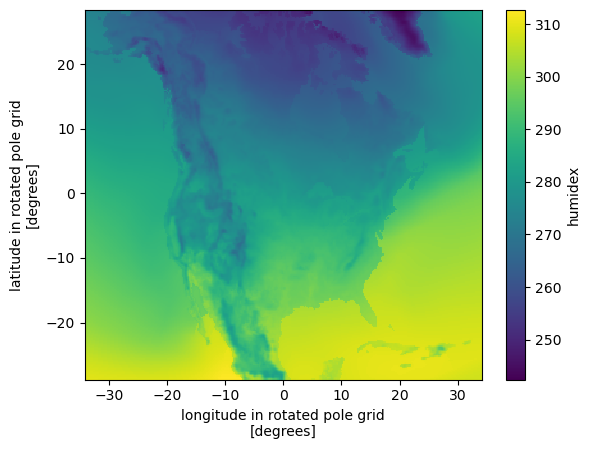

In [47]:
testscen = "historical"
testpath = originalinput.replace("**p", startpara).replace("**s", testscen)
testfile = os.listdir(testpath)[1]
fullpath = os.path.join(testpath,testfile)
td = matchandopentimestamps(fullpath, startpara, paralist)
tros = create(td)
tros.humidex.mean(dim = 'time').plot()
tros

iterating through each of the files, stored in parameter/scenario subfolders, and exporting to new folder

In [ ]:
def iterate(startpara = startpara, scenlist = scenlist, export = False):
    for scen in scenlist:
        path = originalinput.replace("**p", startpara).replace("**s", scen)
        for file in os.listdir(path):
            fullpath = os.path.join(path,file)
            if not os.path.isdir(fullpath):
                d = matchandopentimestamps(fullpath, startpara, paralist)
                outds = create(d)
                outpara = "humidex30"

                # export zone
                if export:
                    newpath = path.replace(startpara,outpara)
                    newname = file.replace(startpara,outpara)
                    newfullpath = fullpath.replace(startpara,outpara)
                    if not os.path.exists(newpath):
                        os.makedirs(newpath)
                    outds.to_netcdf(newfullpath)
                    print(f"dataset saved to {newfullpath}")

In [58]:
iterate(startpara, scenlist, export = True)

AttributeError: 'function' object has no attribute 'attrs'